# Autism Disorder Screening - Children #

## Found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Autistic+Spectrum+Disorder+Screening+Data+for+Children++)

- **Source**: *Fadi Fayez Thabtah*
<br>
    Department of Digital Technology
<br>
    Manukau Institute of Technology
<br>
    Auckland, New Zealand

In [1]:
import io
import os

from autism_data.arff_read import arff_to_df
from autism_data.arff_read import df_get_uniform_dummies

import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
import numpy as np
import os
plt.style.use('seaborn-notebook')

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, confusion_matrix

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

np.set_printoptions(suppress=True)

Using TensorFlow backend.


### Read in the data from UCI website and extract .arff file from zip folder

In [2]:
df = arff_to_df()
df2 = arff_to_df("https://archive.ics.uci.edu/ml/machine-learning-databases/00426/Autism-Adult-Data%20Plus%20Description%20File.zip",'Autism-Adult-Data.arff')
df3 = arff_to_df('https://archive.ics.uci.edu/ml/machine-learning-databases/00420/Autism-Adolescent-Data%20Plus%20Description.zip','Autism-Adolescent-Data.arff')

In [6]:
df = df.append([df2,df3])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1100 entries, 0 to 103
Data columns (total 20 columns):
A1_Score           1100 non-null category
A2_Score           1100 non-null category
A3_Score           1100 non-null category
A4_Score           1100 non-null category
A5_Score           1100 non-null category
A6_Score           1100 non-null category
A7_Score           1100 non-null category
A8_Score           1100 non-null category
A9_Score           1100 non-null category
A10_Score          1100 non-null category
age                1100 non-null float64
gender             1100 non-null category
ethnicity          1100 non-null object
jaundice           1100 non-null int64
autism             1100 non-null int64
used_app_before    1100 non-null int64
result             1100 non-null float64
age_range          1100 non-null object
relation           1100 non-null category
Class/ASD          1100 non-null int64
dtypes: category(12), float64(2), int64(4), object(2)
memory usage: 90.4

### Converting the data and description objects to Pandas DataFrame

- Need to decode the string from utf-8 format to convert to pandas object

In [8]:
df.ethnicity.value_counts()

White-European    381
Asian             185
Unknown           144
Middle_Eastern    128
Black              65
South_Asian        60
Others             57
Latino             33
Hispanic           25
Pasifika           14
Turkish             8
Name: ethnicity, dtype: int64

In [9]:
df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,age,gender,ethnicity,jaundice,autism,used_app_before,result,age_range,relation,Class/ASD
0,1,1,0,0,1,1,0,1,0,0,6.0,m,Others,0,0,0,5.0,'4-11 years',Family Member,0
1,1,1,0,0,1,1,0,1,0,0,6.0,m,Middle_Eastern,0,0,0,5.0,'4-11 years',Family Member,0
2,1,1,0,0,0,1,1,1,0,0,6.0,m,Unknown,0,0,1,5.0,'4-11 years',Unknown,0
3,0,1,0,0,1,1,0,0,0,1,5.0,f,Unknown,1,0,0,4.0,'4-11 years',Unknown,0
4,1,1,1,1,1,1,1,1,1,1,5.0,m,Others,1,0,0,10.0,'4-11 years',Family Member,1


In [10]:
for column in list(df.columns):
    print(column,": ",df[column].nunique())

A1_Score :  2
A2_Score :  2
A3_Score :  2
A4_Score :  2
A5_Score :  2
A6_Score :  2
A7_Score :  2
A8_Score :  2
A9_Score :  2
A10_Score :  2
age :  59
gender :  2
ethnicity :  11
jaundice :  2
autism :  2
used_app_before :  2
result :  11
age_range :  4
relation :  4
Class/ASD :  2


In [11]:
df.columns

Index(['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score',
       'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'age', 'gender',
       'ethnicity', 'jaundice', 'autism', 'used_app_before', 'result',
       'age_range', 'relation', 'Class/ASD'],
      dtype='object')

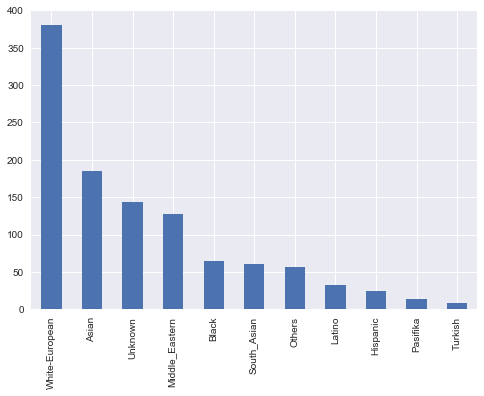

In [12]:
df.ethnicity.value_counts().plot(kind='bar')
plt.show()

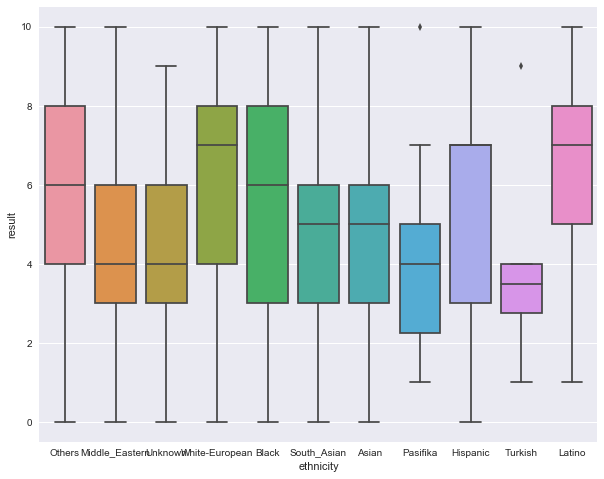

In [13]:
plt.figure(figsize=(10,8))
sb.boxplot(x='ethnicity',y='result',data=df)
plt.show()

In [14]:
df.result.value_counts()

4.0     174
3.0     136
5.0     129
6.0     126
8.0     121
7.0     118
9.0      98
2.0      85
10.0     56
1.0      42
0.0      15
Name: result, dtype: int64

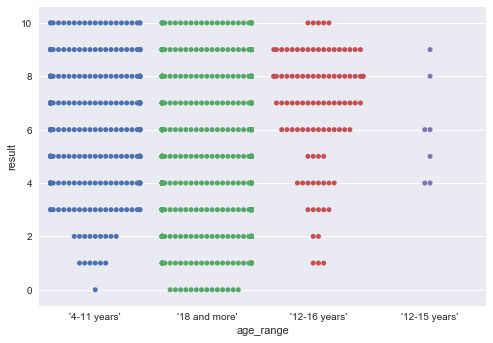

In [15]:
sb.swarmplot(x='age_range',y='result',data=df)
plt.show()

### Exploring the data, some conclusions:
    - Scoring 7 or higher is associated with Autism diagnosis
    - No obvious distinction between the genders, other than males making up a large proportion of the sample
    - Some interesting differences between ethnicities, but not clear if that is meaningful

In [16]:
df.relation.unique()

[Family Member, Unknown, Self, Health care professional]
Categories (4, object): [Family Member, Unknown, Self, Health care professional]

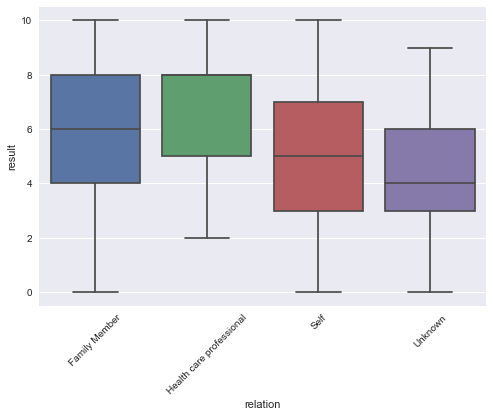

In [17]:
sb.boxplot(x='relation',y='result',data=df)
plt.xticks(rotation=45)
plt.show()

In [18]:
df = df.drop(['result','age'],axis=1)

In [19]:
binary_df = df_get_uniform_dummies(df)
binary_df = binary_df.iloc[:,10:]
binary_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1100 entries, 0 to 103
Data columns (total 21 columns):
jaundice                        1100 non-null int64
autism                          1100 non-null int64
used_app_before                 1100 non-null int64
Class/ASD                       1100 non-null int64
gen_m                           1100 non-null int64
eth_Black                       1100 non-null int64
eth_Hispanic                    1100 non-null int64
eth_Latino                      1100 non-null int64
eth_Middle_Eastern              1100 non-null int64
eth_Others                      1100 non-null int64
eth_Pasifika                    1100 non-null int64
eth_South_Asian                 1100 non-null int64
eth_Turkish                     1100 non-null int64
eth_Unknown                     1100 non-null int64
eth_White-European              1100 non-null int64
age_'12-16 years'               1100 non-null int64
age_'18 and more'               1100 non-null int64
age_'4-11 

** Now we are ready for machine learning! **

In [20]:
def log_loss(predictions,actual,eps=1e-15):
    '''take an array of prediction probabilities (clipped to avoid undefined values) and measures accuracy while
    also factoring for confidence'''
    assert (max(predictions)<=1 and min(predictions)>=0), 'Please make sure to use predict_proba'
    
    preds_clipped = np.clip(predictions,eps,1-eps)
    
    loss = -1 * np.mean((actual * np.log(preds_clipped)) + ((1-actual) * np.log(1-preds_clipped)))
    
    return loss

In [21]:
log_loss(np.array([.5,.85,.25]),np.array([1,1,0]))

0.38111606083650035

In [22]:
bern = BernoulliNB()

In [23]:
binary_features = binary_df.drop('Class/ASD',axis=1)
binary_features.head()

,jaundice,autism,used_app_before,gen_m,eth_Black,eth_Hispanic,eth_Latino,eth_Middle_Eastern,eth_Others,eth_Pasifika,eth_South_Asian,eth_Turkish,eth_Unknown,eth_White-European,age_'12-16 years',age_'18 and more',age_'4-11 years',rel_Health care professional,rel_Self,rel_Unknown
0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
4,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [24]:
X_train, X_test, y_train, y_test = train_test_split(binary_features.values,binary_df['Class/ASD'].values,random_state=12)

In [25]:
bern.fit(X_train, y_train)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [26]:
bern_y_pred = bern.predict(X_test)
bern_y_pred_proba = bern.predict_proba(X_test)
print(len(bern_y_pred[bern_y_pred == y_test])/len(y_test))

0.7090909090909091


In [27]:
precision_score(bern_y_pred,y_test)

0.4777777777777778

In [28]:
accuracy_score(bern_y_pred,y_test)

0.7090909090909091

In [29]:
log_loss(bern_y_pred_proba[:,1],y_test)

0.5840381611101252

In [30]:
for b in binary_features.columns:
    print('{}: {}'.format(b,binary_features[b].sum()))

jaundice: 165
autism: 154
used_app_before: 27
gen_m: 625
eth_Black: 65
eth_Hispanic: 25
eth_Latino: 33
eth_Middle_Eastern: 128
eth_Others: 57
eth_Pasifika: 14
eth_South_Asian: 60
eth_Turkish: 8
eth_Unknown: 144
eth_White-European: 381
age_'12-16 years': 97
age_'18 and more': 704
age_'4-11 years': 292
rel_Health care professional: 23
rel_Self: 572
rel_Unknown: 152


In [31]:
logreg = LogisticRegression()

In [32]:
logreg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
y_logreg_pred = logreg.predict(X_test)

In [34]:
y_logreg_pred

array([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0], dtype=int64)

In [35]:
accuracy_score(y_logreg_pred,y_test)

0.7054545454545454

In [36]:
precision_score(y_logreg_pred,y_test)

0.36666666666666664

In [37]:
y_logreg_pred_proba = logreg.predict_proba(X_test)
log_loss(y_logreg_pred_proba[:,1],y_test)

0.5488729892485905

In [38]:
features_all = binary_df.drop(['Class/ASD'],axis=1)
target = binary_df.loc[:,['Class/ASD']]

In [39]:
features_all.head()

,jaundice,autism,used_app_before,gen_m,eth_Black,eth_Hispanic,eth_Latino,eth_Middle_Eastern,eth_Others,eth_Pasifika,eth_South_Asian,eth_Turkish,eth_Unknown,eth_White-European,age_'12-16 years',age_'18 and more',age_'4-11 years',rel_Health care professional,rel_Self,rel_Unknown
0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
2,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
3,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
4,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [40]:
log_fp,log_tp, log_thresholds = roc_curve(y_test,y_logreg_pred_proba[:,1])
bern_fp, bern_tp, bern_thresholds = roc_curve(y_test,bern_y_pred_proba[:,1])

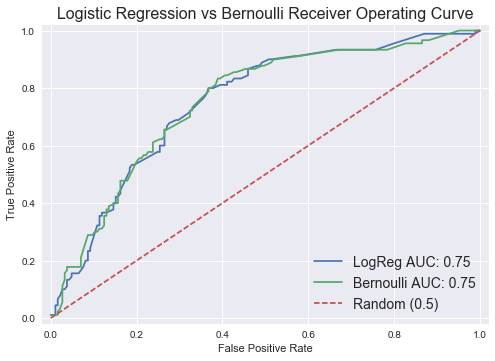

In [41]:
log_AUC = round(roc_auc_score(y_test,y_logreg_pred_proba[0:,1]),2)
bern_AUC = round(roc_auc_score(y_test,bern_y_pred_proba[:,1]),2)

ax = plt.plot(log_fp,log_tp,label="LogReg AUC: {}".format(log_AUC))
ax = plt.plot(bern_fp,bern_tp,label="Bernoulli AUC: {}".format(bern_AUC))
ax = plt.plot([0,1],[0,1],linestyle='--',label='Random (0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0,fontsize=14)
plt.title('Logistic Regression vs Bernoulli Receiver Operating Curve',fontsize=16)
plt.margins(0.02)
plt.show()

In [42]:
roc_auc_score(y_test,y_logreg_pred_proba[0:,1])

0.7507807807807808

### Conclusion: simple models (Bernoulli and Logistic Regression) may not cut it
     Need to try cross validation before moving to more complex models

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [44]:
neighbors = np.arange(1,10)

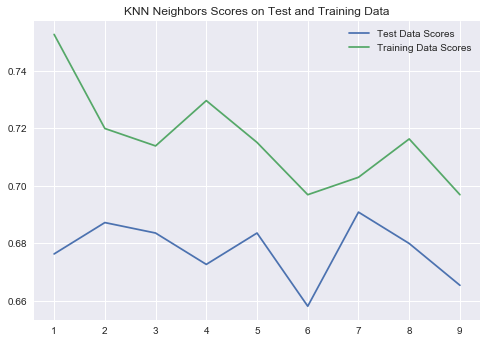

In [45]:
test_scores = np.empty(len(neighbors))
train_scores = np.empty(len(neighbors))

for i, k in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,y_train)
    test_scores[i] = knn.score(X_test,y_test)
    train_scores[i] = knn.score(X_train,y_train)
    
plt.plot(neighbors,test_scores,label='Test Data Scores')
plt.plot(neighbors,train_scores,label='Training Data Scores')
plt.title('KNN Neighbors Scores on Test and Training Data')
plt.legend(loc=0)
plt.show()

In [46]:
knn_y_pred = knn.predict(X_test)

In [47]:
knn.score(X_train,y_train)

0.696969696969697

In [48]:
knn_pred_proba = knn.predict_proba(X_test)
knn_fp, knn_tp, knn_thresholds = roc_curve(y_test,knn_pred_proba[:,1])
knn_AUC = round(roc_auc_score(y_test,knn_pred_proba[:,1]),2)

In [49]:
knn.score(X_test,y_test)

0.6654545454545454

In [50]:
from sklearn.svm import SVC

In [51]:
svc = SVC()

In [52]:
svc.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [53]:
svc.score(X_train,y_train)

0.673939393939394

In [54]:
svc.score(X_test,y_test)

0.7236363636363636

In [55]:
svc_y_pred = svc.predict(X_test)

In [56]:
svc.decision_function(X_train).shape

(825,)

### Using Decision Tree Classifier ###

In [57]:
from sklearn.tree import DecisionTreeClassifier

In [58]:
tree = DecisionTreeClassifier(min_samples_leaf=10)

In [59]:
tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=10,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [60]:
tree_y_pred = tree.predict(X_test)
tree_y_pred_proba = tree.predict_proba(X_test)

In [61]:
tree.score(X_test,y_test)

0.6872727272727273

In [62]:
fp_t,tp_t, thresholds = roc_curve(y_test,tree_y_pred_proba[:,1])

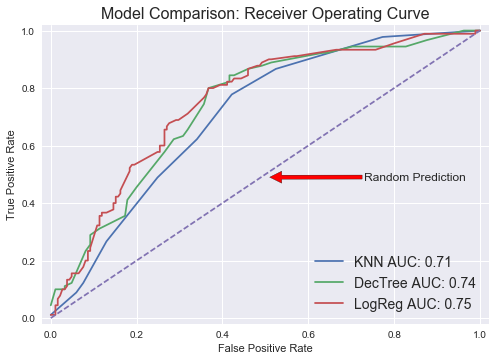

In [63]:
t_AUC = round(roc_auc_score(y_test,tree_y_pred_proba[0:,1]),2)
log_AUC = round(roc_auc_score(y_test,y_logreg_pred_proba[0:,1]),2)

ax = plt.plot(knn_fp,knn_tp,label="KNN AUC: {}".format(knn_AUC))
ax = plt.plot(fp_t,tp_t,label="DecTree AUC: {}".format(t_AUC))
ax = plt.plot(log_fp,log_tp,label="LogReg AUC: {}".format(log_AUC))
ax = plt.plot([0,1],[0,1],linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0,fontsize=14)
plt.title('Model Comparison: Receiver Operating Curve',fontsize=16)
plt.margins(0.02)
plt.annotate("Random Prediction",xy=(.51,.49),xytext=(.73,.48),arrowprops={'facecolor':'red'})
plt.show()

### So far, Logistic Regression provides the most accurate model

In [64]:
mat = np.array([[3,2,5],[6,1,4]])

In [65]:
mat

array([[3, 2, 5],
       [6, 1, 4]])

In [66]:
mat.T

array([[3, 6],
       [2, 1],
       [5, 4]])

In [67]:
mat2 = np.array([[2,4],[1,3],[0,0],[0,0]])

In [68]:
mat2

array([[2, 4],
       [1, 3],
       [0, 0],
       [0, 0]])

In [69]:
mat2.T

array([[2, 1, 0, 0],
       [4, 3, 0, 0]])

In [70]:
prod = mat2 @ mat2.T

In [71]:
prod.diagonal()

array([20, 10,  0,  0])

In [72]:
np.linalg.eig(prod)

(array([29.86606875,  0.13393125,  0.        ,  0.        ]),
 array([[ 0.81741556, -0.57604844,  0.        ,  0.        ],
        [ 0.57604844,  0.81741556,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  1.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]))

In [73]:
w, v = np.linalg.eig(prod)

In [74]:
vec = np.sqrt(w)

In [75]:
eigen_vec = np.diag(vec)[:mat2.shape[0],:mat2.shape[1]]

In [76]:
def singular_value_decomposition(matrix):
    w, v = np.linalg.eig(matrix @ matrix.T)
    svd = np.diag(np.sqrt(w))[:matrix.shape[1],:matrix.shape[1]]
    return svd

In [77]:
singular_value_decomposition(mat2)

array([[5.4649857 , 0.        ],
       [0.        , 0.36596619]])

### Trying out Neural Network Model to Improve Predictions

In [78]:
all_features = binary_df.drop('Class/ASD',axis=1)

In [79]:
feature_matrix = all_features.as_matrix()

feature_columns = feature_matrix.shape[1]

target_split = to_categorical(target)

In [80]:
nnX_train, nnX_test, nny_train, nny_test = train_test_split(feature_matrix,target_split,random_state=12,stratify=target_split)

In [81]:
model = Sequential()

In [82]:
model.add(Dense(100,activation='relu',input_shape=(feature_columns,)))

In [83]:
model.add(Dense(2,activation='softmax'))

In [84]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [85]:
model_training = model.fit(nnX_train,nny_train,batch_size=40,epochs=120)

Epoch 1/120
825/825 [==============================] - 0s 304us/step - loss: 0.6285 - acc: 0.6388
Epoch 2/120
825/825 [==============================] - 0s 19us/step - loss: 0.5853 - acc: 0.6679
Epoch 3/120
825/825 [==============================] - 0s 19us/step - loss: 0.5642 - acc: 0.6812
Epoch 4/120
825/825 [==============================] - 0s 18us/step - loss: 0.5527 - acc: 0.6933
Epoch 5/120
825/825 [==============================] - 0s 18us/step - loss: 0.5449 - acc: 0.6945
Epoch 6/120
825/825 [==============================] - 0s 17us/step - loss: 0.5406 - acc: 0.7018

In [86]:
positive_preds = model.predict(nnX_test)

In [87]:
log_loss(positive_preds[:,1],nny_test[:,1])

0.630924804675509

In [88]:
nn_fpr, nn_tpr, nn_thresh = roc_curve(nny_test[:,1],positive_preds[:,1])

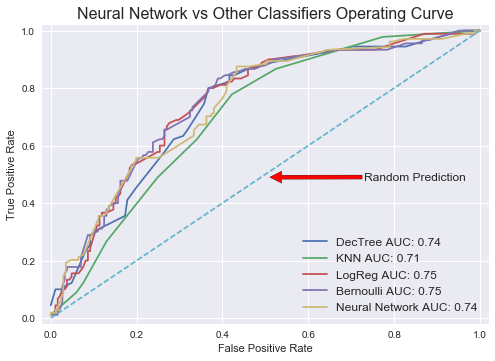

In [89]:
t_AUC = round(roc_auc_score(y_test,tree_y_pred_proba[0:,1]),2)
log_AUC = round(roc_auc_score(y_test,y_logreg_pred_proba[0:,1]),2)
nn_AUC = round(roc_auc_score(nny_test[:,1],positive_preds[:,1]),2)

ax = plt.plot(fp_t,tp_t,label="DecTree AUC: {}".format(t_AUC))
ax = plt.plot(knn_fp,knn_tp,label="KNN AUC: {}".format(knn_AUC))
ax = plt.plot(log_fp,log_tp,label="LogReg AUC: {}".format(log_AUC))
ax = plt.plot(bern_fp,bern_tp,label="Bernoulli AUC: {}".format(bern_AUC))
ax = plt.plot(nn_fpr,nn_tpr,label="Neural Network AUC: {}".format(nn_AUC))
ax = plt.plot([0,1],[0,1],linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=0,fontsize=12)
plt.title('Neural Network vs Other Classifiers Operating Curve',fontsize=16)
plt.margins(0.02)
plt.annotate("Random Prediction",xy=(.51,.49),xytext=(.73,.48),arrowprops={'facecolor':'red'})
plt.show()

### Looking at the Epoch history of Neural Network model

In [90]:
history = model_training.history

In [91]:
nn_history = pd.DataFrame(history)

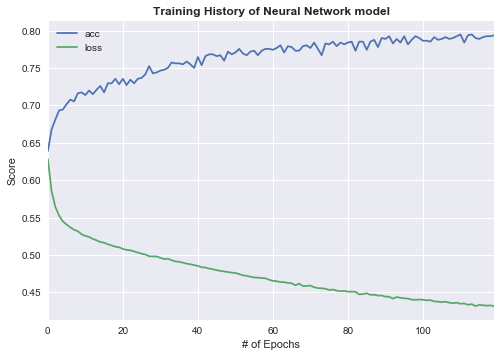

In [94]:
nn_history.plot()
plt.xlabel('# of Epochs')
plt.ylabel('Score')
plt.title('Training History of Neural Network model',fontweight='bold')
plt.show()